In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_excel('report_2018-10-08_SP_eligibility.xlsx')

In [3]:
data.head()

,Mailing,Date,sp_eligibility_tier,sp_discount,customerId,Unique recipients
0,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_4,3.0,8077796.0,1
1,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_5,NaN,11333318.0,1
2,5% Savingplan renewal_opt_in CERTONA,2018-09-16,TIER_4,3.0,9941058.0,1
3,5% Savingplan renewal_opt_in CERTONA,2018-09-17,NO_TIER,5.0,6631853.0,1
4,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_4,NaN,10207899.0,1


In [4]:
data['customerId'] = data['customerId'].fillna(0).astype(int)

In [5]:
data['sp_discount'] = data['sp_discount'].fillna(0).astype(int)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5717 entries, 0 to 5716
Data columns (total 6 columns):
Mailing                5717 non-null object
Date                   5717 non-null datetime64[ns]
sp_eligibility_tier    5552 non-null object
sp_discount            5717 non-null int32
customerId             5717 non-null int32
Unique recipients      5717 non-null int64
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 223.4+ KB


In [7]:
data['sp_eligibility_tier'].unique()

array(['TIER_4', 'TIER_5', 'NO_TIER', 'TIER_6', 'ROYAL_CANIN', nan],
      dtype=object)

In [8]:
data['Mailing'].unique()

array(['5% Savingplan renewal_opt_in CERTONA',
       '3% Savingplan renewal_opt-in CERTONA',
       'Sparplan 3% Reaktivierung CERTONA',
       'Sparplan 3% Reminder CERTONA',
       'Sparplan 5% Reaktivierung CERTONA',
       'Sparplan 5% Reminder CERTONA',
       'BE - SP5 - Renewal Saving Plan 5% (8 recommended products) - CERTONA',
       'BE - SP3 - Renewal Saving Plan 3% (8 recommended products) - CERTONA ',
       'Sparplan No Purchase 60 days with opt-in CERTONA',
       'Sparplan No Purchase 60 days NO opt-in',
       'Sparplan 3% Promo Tier_4 CERTONA',
       'Sparplan 5% Promo Tier_5 CERTONA',
       'BE - SPR - Savings Plan No Purchase - Opt-in - CERTONA',
       'BE - SPRNO - Savings Plan No Purchase - No Opt-in',
       '3% Savingplan promotion CERTONA',
       '5% Savingplan promotion CERTONA',
       'Saving plan reactivation_opt-in_costumers CERTONA',
       'Saving plan reactivation_without_opt-in_costumers',
       'Savings Plan No Purchase after 60 days without Opt

In [14]:
checklist = list(zip(data[data['customerId'] != 0]['customerId'], data[data['customerId'] != 0]['Date'].dt.date))

In [33]:
len(checklist)

5552

In [34]:
len(data[data['customerId'] == 0])

165

In [15]:
cus_df = pd.DataFrame(checklist, columns=['CUSTOMER_ID', 'DATE'])

In [16]:
checklist

[(8077796, datetime.date(2018, 9, 15)),
 (11333318, datetime.date(2018, 9, 15)),
 (9941058, datetime.date(2018, 9, 16)),
 (6631853, datetime.date(2018, 9, 17)),
 (10207899, datetime.date(2018, 9, 17)),
 (9957227, datetime.date(2018, 9, 17)),
 (17657926, datetime.date(2018, 9, 17)),
 (9621397, datetime.date(2018, 9, 18)),
 (12344991, datetime.date(2018, 9, 19)),
 (10121471, datetime.date(2018, 9, 19)),
 (11428174, datetime.date(2018, 9, 19)),
 (6722761, datetime.date(2018, 9, 20)),
 (11498232, datetime.date(2018, 9, 20)),
 (12215671, datetime.date(2018, 9, 20)),
 (9998984, datetime.date(2018, 9, 20)),
 (12434829, datetime.date(2018, 9, 21)),
 (7554694, datetime.date(2018, 9, 22)),
 (17139375, datetime.date(2018, 9, 24)),
 (10488028, datetime.date(2018, 9, 24)),
 (16848454, datetime.date(2018, 9, 24)),
 (16316015, datetime.date(2018, 9, 25)),
 (10373036, datetime.date(2018, 9, 25)),
 (11189025, datetime.date(2018, 9, 25)),
 (11681236, datetime.date(2018, 9, 25)),
 (15164740, datetime.dat

Let's query ZOO_DATAMARTS.MV_LOY_SP_ELIGIBILITY_CHANGES and get from those customers their eligibility status at the date provided...

In [21]:
cus_data = pd.DataFrame(columns=['EC_EXT_K_ID', 'EC_TIER_ID', 'EC_CHANGED_ON', 'EC_ENDED_ON'])

conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")

for i, j in list(zip(cus_df['CUSTOMER_ID'], cus_df['DATE'])):
    values = {"customer": i, "date": j}
    query = """select EC_EXT_K_ID, EC_TIER_ID, EC_CHANGED_ON, EC_ENDED_ON
               from ZOO_DATAMARTS.MV_LOY_SP_ELIGIBILITY_CHANGES 
               where EC_EXT_K_ID = {customer}
               and ((to_date('{date}', 'yyyy/mm/dd') between EC_CHANGED_ON and EC_ENDED_ON) or
                    ((to_date('{date}', 'yyyy/mm/dd') >= EC_CHANGED_ON) and (EC_ENDED_ON is null)))
               """.format(**values)
    cus_elig_data = pd.read_sql(query, con = conn)
    cus_data = pd.concat([cus_data, cus_elig_data], ignore_index=True)
    
conn.close()  

In [22]:
len(cus_data), len(cus_df)

(5552, 5552)

In [23]:
cus_data.to_csv('eligibilities_from_oracle.csv', sep=';', index=False, encoding='utf-8')

In [65]:
cus_data.head()

,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON
0,8077796,4,2018-08-05 01:02:31.020020,2018-09-16 01:01:18.262597
1,11333318,5,2018-08-05 01:03:25.353432,2018-09-16 01:01:37.321320
2,9941058,4,2018-08-06 01:02:40.757765,2018-09-17 01:01:19.479093
3,6631853,5,2018-08-07 01:02:28.686264,2018-09-18 01:03:42.865621
4,10207899,4,2018-08-07 01:03:16.368909,2018-09-18 01:04:10.597389


In [66]:
customer_df = pd.concat([cus_df, cus_data], axis=1)

In [76]:
customer_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5552 entries, 0 to 5551
Data columns (total 6 columns):
CUSTOMER_ID      5552 non-null int64
DATE             5552 non-null datetime64[ns]
EC_EXT_K_ID      5552 non-null object
EC_TIER_ID       5552 non-null object
EC_CHANGED_ON    5552 non-null datetime64[ns]
EC_ENDED_ON      1368 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 260.3+ KB


In [75]:
customer_df.head()

,CUSTOMER_ID,DATE,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON
0,8077796,2018-09-15,8077796,4,2018-08-05 01:02:31.020020,2018-09-16 01:01:18.262597
1,11333318,2018-09-15,11333318,5,2018-08-05 01:03:25.353432,2018-09-16 01:01:37.321320
2,9941058,2018-09-16,9941058,4,2018-08-06 01:02:40.757765,2018-09-17 01:01:19.479093
3,6631853,2018-09-17,6631853,5,2018-08-07 01:02:28.686264,2018-09-18 01:03:42.865621
4,10207899,2018-09-17,10207899,4,2018-08-07 01:03:16.368909,2018-09-18 01:04:10.597389


In [77]:
len(customer_df)

5552

In [69]:
data[data['customerId'] == 8106923]

,Mailing,Date,sp_eligibility_tier,sp_discount,customerId,Unique recipients
492,BE - SP5 - Renewal Saving Plan 5% (8 recommend...,2018-09-30,NO_TIER,0,8106923,1
3393,BE - SPR - Savings Plan No Purchase - Opt-in -...,2018-09-21,NO_TIER,0,8106923,1


In [70]:
data.info(), customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5717 entries, 0 to 5716
Data columns (total 6 columns):
Mailing                5717 non-null object
Date                   5717 non-null datetime64[ns]
sp_eligibility_tier    5552 non-null object
sp_discount            5717 non-null int32
customerId             5717 non-null int32
Unique recipients      5717 non-null int64
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 223.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5552 entries, 0 to 5551
Data columns (total 6 columns):
CUSTOMER_ID      5552 non-null int64
DATE             5552 non-null object
EC_EXT_K_ID      5552 non-null object
EC_TIER_ID       5552 non-null object
EC_CHANGED_ON    5552 non-null datetime64[ns]
EC_ENDED_ON      1368 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 260.3+ KB


(None, None)

In [71]:
customer_df['DATE'] = pd.to_datetime(customer_df['DATE'], format="%Y-%m-%d")

In [72]:
cus_elig = data.merge(customer_df, left_on=['customerId', 'Date'], right_on=['EC_EXT_K_ID', 'DATE'], how='inner')

In [73]:
len(cus_elig)

5552

In [81]:
cus_elig[cus_elig['customerId'] == 9941058]

,Mailing,Date,sp_eligibility_tier,sp_discount,customerId,Unique recipients,CUSTOMER_ID,DATE,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON
2,5% Savingplan renewal_opt_in CERTONA,2018-09-16,TIER_4,3,9941058,1,9941058,2018-09-16,9941058,4,2018-08-06 01:02:40.757765,2018-09-17 01:01:19.479093


In [83]:
del cus_elig['CUSTOMER_ID']
del cus_elig['DATE']

In [84]:
cus_elig['sp_eligibility_tier'].unique()

array(['TIER_4', 'TIER_5', 'NO_TIER', 'TIER_6', 'ROYAL_CANIN'],
      dtype=object)

In [85]:
sp_elig = [4 if i == 'TIER_4' else (5 if i == 'TIER_5' else (6 if i == 'TIER_6' else (1000 if i == 'ROYAL_CANIN' else 0))) for i in cus_elig['sp_eligibility_tier'].values]

In [86]:
cus_elig['sp_elig_tier'] = sp_elig

In [87]:
cus_elig[['sp_elig_tier', 'sp_eligibility_tier']].sample(10)

,sp_elig_tier,sp_eligibility_tier
2350,5,TIER_5
1758,0,NO_TIER
4780,4,TIER_4
2682,5,TIER_5
3238,0,NO_TIER
2962,0,NO_TIER
961,5,TIER_5
229,0,NO_TIER
4998,0,NO_TIER
621,5,TIER_5


In [92]:
pd.pivot_table(cus_elig, values='customerId', index='sp_elig_tier', columns='EC_TIER_ID', aggfunc='count').fillna(0).astype(int)

EC_TIER_ID,0,4,5,6
sp_elig_tier,,,,
0,3615,46,28,0
4,41,1017,9,0
5,35,2,706,2
6,1,0,2,47
1000,0,0,1,0


In [89]:
cus_elig.to_csv('eligibilities_from_episerver_and_oracle.csv', sep=';', index=False, encoding='utf-8')

In [10]:
cus_elig = pd.read_csv('eligibilities_from_episerver_and_oracle.csv', sep=';')

In [15]:
cus_elig

,Mailing,Date,sp_eligibility_tier,sp_discount,customerId,Unique recipients,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON,sp_elig_tier
0,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_4,3,8077796,1,8077796,4,2018-08-05 01:02:31.020020,2018-09-16 01:01:18.262597,4
1,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_5,0,11333318,1,11333318,5,2018-08-05 01:03:25.353432,2018-09-16 01:01:37.321320,5
2,5% Savingplan renewal_opt_in CERTONA,2018-09-16,TIER_4,3,9941058,1,9941058,4,2018-08-06 01:02:40.757765,2018-09-17 01:01:19.479093,4
3,5% Savingplan renewal_opt_in CERTONA,2018-09-17,NO_TIER,5,6631853,1,6631853,5,2018-08-07 01:02:28.686264,2018-09-18 01:03:42.865621,0
4,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_4,0,10207899,1,10207899,4,2018-08-07 01:03:16.368909,2018-09-18 01:04:10.597389,4
5,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_4,0,9957227,1,9957227,4,2018-08-07 01:02:42.584760,2018-09-18 01:03:55.193929,4
6,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_5,0,17657926,1,17657926,5,2018-08-07 01:02:31.645667,2018-09-18 01:03:56.772418,5
7,5% Savingplan renewal_opt_in CERTONA,2018-09-18,TIER_4,0,9621397,1,9621397,4,2018-08-08 01:01:31.132999,2018-09-18 12:36:37.469652,4
8,5% Savingplan renewal_opt_in CERTONA,2018-09-19,NO_TIER,0,12344991,1,12344991,0,2018-07-31 00:00:00.000000,NaT,0
9,5% Savingplan renewal_opt_in CERTONA,2018-09-19,TIER_4,0,10121471,1,10121471,4,2018-08-09 01:02:23.826635,2018-09-20 01:01:37.642166,4


In [14]:
cus_elig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5552 entries, 0 to 5551
Data columns (total 11 columns):
Mailing                5552 non-null object
Date                   5552 non-null datetime64[ns]
sp_eligibility_tier    5552 non-null object
sp_discount            5552 non-null int64
customerId             5552 non-null int64
Unique recipients      5552 non-null int64
EC_EXT_K_ID            5552 non-null int64
EC_TIER_ID             5552 non-null int64
EC_CHANGED_ON          5552 non-null datetime64[ns]
EC_ENDED_ON            1368 non-null datetime64[ns]
sp_elig_tier           5552 non-null int64
dtypes: datetime64[ns](3), int64(6), object(2)
memory usage: 477.2+ KB


In [13]:
cus_elig['Date'] = pd.to_datetime(cus_elig['Date'], format="%Y/%m/%d %H:%M:%S")
cus_elig['EC_CHANGED_ON'] = pd.to_datetime(cus_elig['EC_CHANGED_ON'], format="%Y/%m/%d %H:%M:%S")
cus_elig['EC_ENDED_ON'] = pd.to_datetime(cus_elig['EC_ENDED_ON'], format="%Y/%m/%d %H:%M:%S")

In [17]:
customers = list(cus_elig['EC_EXT_K_ID'].unique())

In [21]:
len(customers)

5498

In [23]:
request_customers_list = [0, 1000, 2000, 3000, 4000, 5000, 6000]

In [25]:
customers_df = pd.DataFrame(columns=['K_ID', 'K_REGISTRATION_S_ID'])

conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")

for i, j in list(zip(request_customers_list[:-1], request_customers_list[1:])):
    custom = customers[i:j]
    cus_list = repr(custom).replace('[','(').replace(']',')')
    query = """select k_id, k_registration_s_id from ZOOMAN.KUNDEN
    where k_id in %s""" % cus_list
    custom_df = pd.read_sql(query, con = conn)
    customers_df = pd.concat([customers_df, custom_df], ignore_index=True)
    print(j)

conn.close()

1000
2000
3000
4000
5000
6000


In [27]:
customers_df.head()

,K_ID,K_REGISTRATION_S_ID
0,1843386,14
1,2001703,14
2,2010815,14
3,2083504,14
4,2367246,14


In [28]:
customers_df['K_ID'] = customers_df['K_ID'].astype(int)

In [29]:
customers_df['K_REGISTRATION_S_ID'] = customers_df['K_REGISTRATION_S_ID'].astype(int)

In [30]:
customers_df['K_REGISTRATION_S_ID'].value_counts()

14    2346
25    2312
23     743
30      97
Name: K_REGISTRATION_S_ID, dtype: int64

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
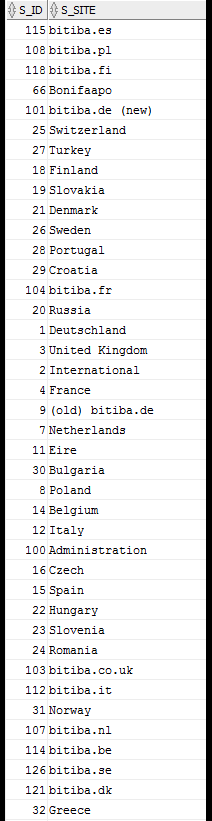

In [31]:
len(cus_elig)

5552

In [32]:
cus_elig = cus_elig.merge(customers_df, how='left', left_on='EC_EXT_K_ID', right_on='K_ID')

In [34]:
del cus_elig['K_ID']

MadGyvers inform us that Optivo sends emails depending on the registration site of the customer...let's see the different sp discounts available for the countries found in our data

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
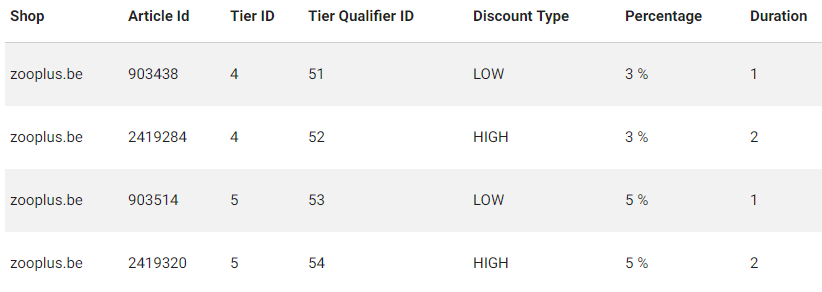

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
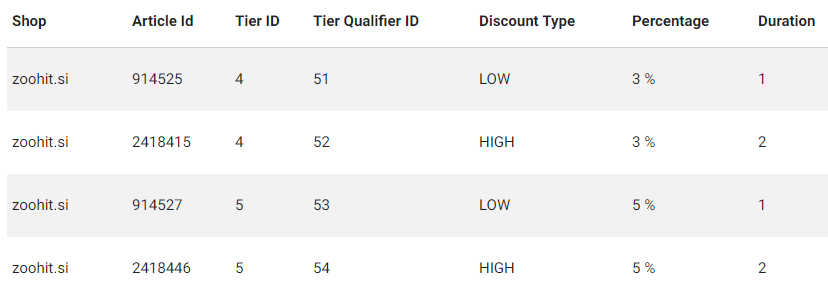

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
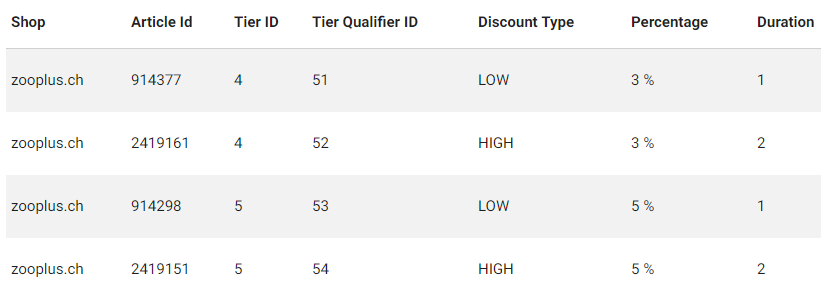

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
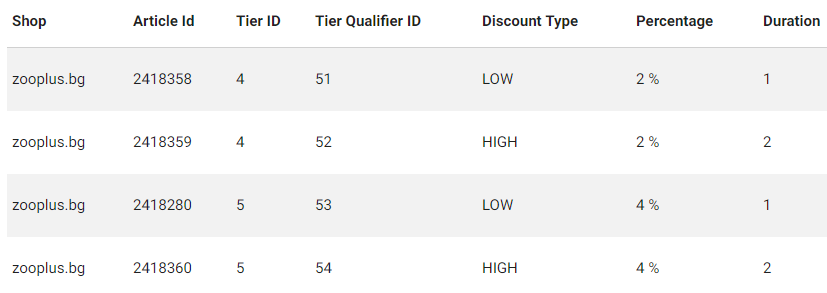

In [46]:
sp_disc_offer = [2 if i == 4 and j == 30 else (4 if i == 5 and j == 30 else (3 if i == 4 else (5 if i == 5 else (999 if i == 6 else 0)))) for i, j in list(zip(cus_elig['EC_TIER_ID'].values, cus_elig['K_REGISTRATION_S_ID'].values))]

In [47]:
len(cus_elig) == len(sp_disc_offer)

True

In [48]:
cus_elig['sp_disc_based_on_site_n_tier'] = sp_disc_offer

In [52]:
cus_elig.sample(10)

,Mailing,Date,sp_eligibility_tier,sp_discount,customerId,Unique recipients,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON,sp_elig_tier,K_REGISTRATION_S_ID,sp_disc_based_on_site_n_tier
1735,Sparplan No Purchase 60 days with opt-in CERTONA,2018-09-27,NO_TIER,5,8609688,1,8609688,0,2018-07-31 00:00:00.000000,NaT,0,25,0
4070,BE - SPR - Savings Plan No Purchase - Opt-in -...,2018-09-29,NO_TIER,5,8695207,1,8695207,0,2018-07-31 00:00:00.000000,NaT,0,14,0
2459,Sparplan 3% Promo Tier_4 CERTONA,2018-09-26,TIER_4,0,19101356,1,19101356,4,2018-09-04 03:56:18.412879,NaT,4,25,3
1625,Sparplan No Purchase 60 days with opt-in CERTONA,2018-09-26,NO_TIER,3,16343731,1,16343731,0,2018-07-31 00:00:00.000000,NaT,0,25,0
178,Sparplan 3% Reaktivierung CERTONA,2018-09-18,TIER_5,0,17951641,1,17951641,5,2018-08-08 01:01:33.810766,2018-09-19 01:02:40.955444,5,25,5
4120,BE - SPR - Savings Plan No Purchase - Opt-in -...,2018-09-30,NO_TIER,3,5734047,1,5734047,0,2018-07-31 00:00:00.000000,NaT,0,14,0
4506,BE - SPR - Savings Plan No Purchase - Opt-in -...,2018-10-04,NO_TIER,3,9169587,1,9169587,0,2018-07-31 00:00:00.000000,NaT,0,14,0
1729,Sparplan No Purchase 60 days with opt-in CERTONA,2018-09-27,NO_TIER,5,7449975,1,7449975,0,2018-07-31 00:00:00.000000,NaT,0,25,0
4581,BE - SPR - Savings Plan No Purchase - Opt-in -...,2018-10-05,NO_TIER,3,17363824,1,17363824,0,2018-08-06 21:44:19.585797,NaT,0,14,0
3242,BE - SPR - Savings Plan No Purchase - Opt-in -...,2018-09-20,NO_TIER,3,15697413,1,15697413,0,2018-07-31 00:00:00.000000,NaT,0,14,0


In [65]:
cus_elig['Date'][0]

Timestamp('2018-09-15 00:00:00')

Let's check now sp actives for each customer ID and the date provided...

In [104]:
czp_df = pd.DataFrame(columns=['CZP_K_ID', 'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_PERCENTAGE', 'K_ID', 'DATE'])

conn = cx_Oracle.connect('readonly', 'read_123', 'db-zpmstb-01:1521/zpmstb.web.zooplus.de', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")

for i, j in list(zip(cus_elig['EC_EXT_K_ID'], cus_elig['Date'])):
    values = {"customer": i, "date": j}
    query = """select CZP_K_ID, CZP_START_DATE, CZP_EXPIRY_DATE, CZP_PERCENTAGE
               from ZOOMAN.CUSTOMERS_ZOOPRIME_PLANS 
               where CZP_K_ID = {customer}
               and CZP_START_DATE <= to_date('{date}', 'yyyy/mm/dd HH24:MI:SS') 
               and CZP_EXPIRY_DATE > to_date('{date}', 'yyyy/mm/dd HH24:MI:SS')
               """.format(**values)
    cus_czp_data = pd.read_sql(query, con = conn)
    
    if len(cus_czp_data) == 0:
        cus_czp_data = pd.DataFrame(np.array([None, None, None, None, i, j]).reshape(1,6), columns = czp_df.columns)
    else:
        cus_czp_data['K_ID'] = i
        cus_czp_data['DATE'] = j
        
    czp_df = pd.concat([czp_df, cus_czp_data], ignore_index=True)
    
conn.close()

In [105]:
len(cus_elig), len(czp_df)

(5552, 5574)

In [117]:
dupl_customers = list(czp_df[czp_df[['K_ID', 'DATE']].duplicated()]['CZP_K_ID'].values)

In [121]:
# 22 customers duplicated
czp_df[czp_df['K_ID'].isin(dupl_customers)]['CZP_K_ID'].value_counts()

18118361    3
9820275     3
17695434    3
18114623    2
8621899     2
16970178    2
8015529     2
14548388    2
6353797     2
9436841     2
17136872    2
6722761     2
7173644     2
18044667    2
18067856    2
17819314    2
8209684     2
6522389     2
9618422     2
18099462    2
8904376     2
17079905    2
Name: CZP_K_ID, dtype: int64

In [124]:
dupl_indexes = []

for i in dupl_customers:
    cus = czp_df[czp_df['K_ID'] == i]
    min_date = cus['CZP_START_DATE'].min()
    not_valid = cus[cus['CZP_START_DATE'] != min_date].index.values
    dupl_indexes.append(not_valid)

In [130]:
dup_index = [j for i in dupl_indexes for j in i]

In [131]:
len(dup_index)

22

In [132]:
#Drop duplicated indexes
czp_df.drop(dup_index, inplace=True)

In [133]:
czp_df[czp_df['K_ID'].isin(dupl_customers)]['CZP_K_ID'].value_counts()

18118361    2
9820275     2
17695434    2
18114623    1
8621899     1
16970178    1
8015529     1
14548388    1
6353797     1
9436841     1
17136872    1
6722761     1
7173644     1
18044667    1
18067856    1
17819314    1
8209684     1
6522389     1
9618422     1
18099462    1
8904376     1
17079905    1
Name: CZP_K_ID, dtype: int64

In [135]:
len(czp_df)

5552

In [136]:
czp_df[czp_df['K_ID'].isin(dupl_customers)]

,CZP_K_ID,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_PERCENTAGE,K_ID,DATE
11,6722761,2017-09-20 10:34:12,2018-09-20 23:59:59,5,6722761,2018-09-20 00:00:00
35,14548388,2017-10-02 21:58:37,2018-10-02 23:59:59,3,14548388,2018-10-02 00:00:00
54,8904376,2015-08-25 12:31:02,2018-09-17 23:59:59,3,8904376,2018-09-17 00:00:00
137,17079905,2017-10-04 16:51:28,2018-10-04 23:59:59,5,17079905,2018-10-04 00:00:00
234,9820275,2015-09-10 17:42:09,2018-09-26 23:59:59,5,9820275,2018-09-26 00:00:00
254,6522389,2015-10-04 17:53:01,2018-10-04 23:59:59,5,6522389,2018-10-04 00:00:00
343,8209684,2015-08-27 15:19:10,2018-09-26 23:59:59,3,8209684,2018-09-26 00:00:00
383,18114623,2017-10-04 19:41:33,2018-10-04 23:59:59,5,18114623,2018-10-04 00:00:00
387,18118361,2017-10-05 07:18:07,2018-10-05 23:59:59,5,18118361,2018-10-05 00:00:00
411,7173644,2017-09-15 11:40:30,2018-09-15 23:59:59,5,7173644,2018-09-15 00:00:00


In [137]:
czp_df[czp_df[['K_ID', 'DATE']].duplicated()]

,CZP_K_ID,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_PERCENTAGE,K_ID,DATE


In [138]:
len(czp_df)

5552

In [139]:
czp_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5552 entries, 0 to 5573
Data columns (total 6 columns):
CZP_K_ID           4733 non-null object
CZP_START_DATE     4733 non-null datetime64[ns]
CZP_EXPIRY_DATE    4733 non-null datetime64[ns]
CZP_PERCENTAGE     4733 non-null object
K_ID               5552 non-null object
DATE               5552 non-null object
dtypes: datetime64[ns](2), object(4)
memory usage: 303.6+ KB


In [152]:
czp_df['K_ID'] = czp_df['K_ID'].astype(int)

In [153]:
czp_df['DATE'] = pd.to_datetime(czp_df['DATE'], format="%Y-%m-%d HH:MM:SS")

In [154]:
customer_data = pd.merge(cus_elig, czp_df, how='left', left_on=['EC_EXT_K_ID', 'Date'],
                              right_on=['K_ID', 'DATE'])

In [155]:
customer_data

,Mailing,Date,sp_eligibility_tier,sp_discount,customerId,Unique recipients,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON,sp_elig_tier,K_REGISTRATION_S_ID,sp_disc_based_on_site_n_tier,CZP_K_ID,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_PERCENTAGE,K_ID,DATE
0,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_4,3,8077796,1,8077796,4,2018-08-05 01:02:31.020020,2018-09-16 01:01:18.262597,4,23,3,8077796,2017-09-15 09:20:06,2018-09-15 23:59:59,5,8077796,2018-09-15
1,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_5,0,11333318,1,11333318,5,2018-08-05 01:03:25.353432,2018-09-16 01:01:37.321320,5,23,5,11333318,2017-09-15 20:11:51,2018-09-15 23:59:59,5,11333318,2018-09-15
2,5% Savingplan renewal_opt_in CERTONA,2018-09-16,TIER_4,3,9941058,1,9941058,4,2018-08-06 01:02:40.757765,2018-09-17 01:01:19.479093,4,23,3,9941058,2015-09-16 10:03:22,2018-09-16 23:59:59,5,9941058,2018-09-16
3,5% Savingplan renewal_opt_in CERTONA,2018-09-17,NO_TIER,5,6631853,1,6631853,5,2018-08-07 01:02:28.686264,2018-09-18 01:03:42.865621,0,23,5,6631853,2017-09-17 17:42:35,2018-09-17 23:59:59,5,6631853,2018-09-17
4,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_4,0,10207899,1,10207899,4,2018-08-07 01:03:16.368909,2018-09-18 01:04:10.597389,4,23,3,10207899,2017-09-17 20:34:03,2018-09-17 23:59:59,5,10207899,2018-09-17
5,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_4,0,9957227,1,9957227,4,2018-08-07 01:02:42.584760,2018-09-18 01:03:55.193929,4,23,3,9957227,2015-09-17 22:09:15,2018-09-17 23:59:59,5,9957227,2018-09-17
6,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_5,0,17657926,1,17657926,5,2018-08-07 01:02:31.645667,2018-09-18 01:03:56.772418,5,23,5,17657926,2017-09-17 09:00:31,2018-09-17 23:59:59,5,17657926,2018-09-17
7,5% Savingplan renewal_opt_in CERTONA,2018-09-18,TIER_4,0,9621397,1,9621397,4,2018-08-08 01:01:31.132999,2018-09-18 12:36:37.469652,4,23,3,9621397,2017-09-18 20:06:42,2018-09-18 23:59:59,5,9621397,2018-09-18
8,5% Savingplan renewal_opt_in CERTONA,2018-09-19,NO_TIER,0,12344991,1,12344991,0,2018-07-31 00:00:00.000000,NaT,0,23,0,12344991,2017-09-19 09:26:34,2018-09-19 23:59:59,5,12344991,2018-09-19
9,5% Savingplan renewal_opt_in CERTONA,2018-09-19,TIER_4,0,10121471,1,10121471,4,2018-08-09 01:02:23.826635,2018-09-20 01:01:37.642166,4,23,3,10121471,2015-09-14 13:06:39,2018-09-19 23:59:59,5,10121471,2018-09-19


In [158]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5552 entries, 0 to 5551
Data columns (total 17 columns):
Mailing                         5552 non-null object
Date                            5552 non-null datetime64[ns]
sp_eligibility_tier             5552 non-null object
sp_discount                     5552 non-null int64
customerId                      5552 non-null int64
Unique recipients               5552 non-null int64
EC_EXT_K_ID                     5552 non-null int64
EC_TIER_ID                      5552 non-null int64
EC_CHANGED_ON                   5552 non-null datetime64[ns]
EC_ENDED_ON                     1368 non-null datetime64[ns]
sp_elig_tier                    5552 non-null int64
K_REGISTRATION_S_ID             5552 non-null int32
sp_disc_based_on_site_n_tier    5552 non-null int64
CZP_K_ID                        4733 non-null object
CZP_START_DATE                  4733 non-null datetime64[ns]
CZP_EXPIRY_DATE                 4733 non-null datetime64[ns]
CZP_PERCENTAG

In [156]:
del customer_data['K_ID']

In [157]:
del customer_data['DATE']

In [159]:
customer_data.columns

Index(['Mailing', 'Date', 'sp_eligibility_tier', 'sp_discount', 'customerId',
       'Unique recipients', 'EC_EXT_K_ID', 'EC_TIER_ID', 'EC_CHANGED_ON',
       'EC_ENDED_ON', 'sp_elig_tier', 'K_REGISTRATION_S_ID',
       'sp_disc_based_on_site_n_tier', 'CZP_K_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'CZP_PERCENTAGE'],
      dtype='object')

In [161]:
customer_data = customer_data[['Mailing', 'Date', 'sp_eligibility_tier', 'sp_elig_tier', 'sp_discount', 'customerId',
       'Unique recipients', 'EC_EXT_K_ID', 'EC_TIER_ID', 'EC_CHANGED_ON',
       'EC_ENDED_ON', 'K_REGISTRATION_S_ID',
       'sp_disc_based_on_site_n_tier', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'CZP_PERCENTAGE']]

In [162]:
customer_data.head()

,Mailing,Date,sp_eligibility_tier,sp_elig_tier,sp_discount,customerId,Unique recipients,EC_EXT_K_ID,EC_TIER_ID,EC_CHANGED_ON,EC_ENDED_ON,K_REGISTRATION_S_ID,sp_disc_based_on_site_n_tier,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_PERCENTAGE
0,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_4,4,3,8077796,1,8077796,4,2018-08-05 01:02:31.020020,2018-09-16 01:01:18.262597,23,3,2017-09-15 09:20:06,2018-09-15 23:59:59,5
1,5% Savingplan renewal_opt_in CERTONA,2018-09-15,TIER_5,5,0,11333318,1,11333318,5,2018-08-05 01:03:25.353432,2018-09-16 01:01:37.321320,23,5,2017-09-15 20:11:51,2018-09-15 23:59:59,5
2,5% Savingplan renewal_opt_in CERTONA,2018-09-16,TIER_4,4,3,9941058,1,9941058,4,2018-08-06 01:02:40.757765,2018-09-17 01:01:19.479093,23,3,2015-09-16 10:03:22,2018-09-16 23:59:59,5
3,5% Savingplan renewal_opt_in CERTONA,2018-09-17,NO_TIER,0,5,6631853,1,6631853,5,2018-08-07 01:02:28.686264,2018-09-18 01:03:42.865621,23,5,2017-09-17 17:42:35,2018-09-17 23:59:59,5
4,5% Savingplan renewal_opt_in CERTONA,2018-09-17,TIER_4,4,0,10207899,1,10207899,4,2018-08-07 01:03:16.368909,2018-09-18 01:04:10.597389,23,3,2017-09-17 20:34:03,2018-09-17 23:59:59,5


In [164]:
writer = pd.ExcelWriter('eligibility_sp_customer_info.xlsx')
customer_data.to_excel(writer, index=False)
writer.save()

In [165]:
customer_data.to_pickle("./eligibility_sp_customer_oracle_vs_optivo.pkl")